# Bayesian Quadrature for CVA : a case study on a Swap portfolio 

### Path setup & Libraries :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Projet Quadrature bayésienne'

In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
NumInteg_path = project_path +'\Results\\numerical integration'
img_path = project_path +'\Results\Images'


In [3]:
import numpy as np
import pandas as pd


import pickle
from time import time
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt

# importing pacakge 
import sys         
sys.path.append(lib_path)        
from main import *
from FinancialData import *

## Data extraction :

In [4]:
ZCR = ZC_Data_extractor(zc_curve_path)    
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 



#load portfolio data
with open(port_path+'\port400irs1fx', 'rb') as f1:
    portfolio = pickle.load(f1)
    
# Set Maturity     
T = portfolio.last_maturity

# to dump portfolio in excel 
# irs_specs = np.empty(portfolio.swaps_number,
#                      dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
#                             ('notional', '<f4'), ('swap_rate', '<f4'),
#                             ('maturity', '<f4'), ('exercice', '<U10')])  # We set maturity instead of num_resets
# irs_specs['first_reset']=portfolio.T0

# irs_specs['reset_freq'] = portfolio.freq
# irs_specs['notional'] = portfolio.nominal
# irs_specs['swap_rate'] = portfolio.strike
# irs_specs['exercice'] = portfolio.exercice
# irs_specs['maturity'] = portfolio.maturity
# pd.DataFrame(irs_specs).to_excel(port_path+ '\port400irs1fx.xlsx')


portfolio.print_as_dict()

{'first_reset_date': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [5]:
#load benchmark data : Numerical Integration
with open(NumInteg_path+'\CVA_convergence_P400swapfX1' ,'rb') as f:
    bench_df = pickle.load(f)
    EE_bench = pickle.load(f)

#load diffusion data : Used to get LGM params and to do Monte Carlo
with open(diff_path+'\MC60000p400swap1fx', 'rb') as f1:
    diffusion = pickle.load(f1)

#load MC Calculation 
with open(MC_path+'\CVA_MC_convergence_P400swapfX1' ,'rb') as f:
    mc_df = pickle.load(f)

with open(MC_path+'\EE_MC_converged60000_P400swapfX1' ,'rb') as f:
    EE_MC = pickle.load(f)


In [9]:
mtm = np.mean(portfolio.Mtm(0, diffusion, ZC))
print("Mtm today is  :" , mtm)

Mtm today is  : -54507.57385103298


As benchmark we take the numerical integration with respect to $t$ and $X_{t}$ using 500 discretizations on time and 300 on risk factor. It take 72 seconds

## 1. CVA by numerical integration

In this section, we calculate the CVA of our portfolio based on a numerical intergration of the expected exposure $EE$ with respect to time trough a Reimman sum 

$CVA = (1-R) \, \int_{0}^{T} EE(t) \, dPD(t) \, \approx (1-R) \, \sum_{i=1}^{n} EE(t_{i}) \, PD^{\prime}(t_{i}) (t_{i+1} - t_{i})  $

Also, we present 3 main methods to calculate $EE(t_{i})$ : Numerical integration, Monte Carlo and proxy

In [6]:
#recovery rate & default probability parameter :
R, lamda = 0.4, 0.005

### 1.1. EE by numerical integration

In this section we calculate the EE based on a numerical integration with respect to the risk factor $X_{t}$ as follow 

$EE(t) = B(0,t)\,  \mathbb{E}^{\mathbb{Q}^{t}} \left[ \, V(X_{t})^{+} \,  \right] = B(0,t) \, \int_{-\infty}^{+\infty}   V(x)^{+} \,\phi_{t}(x) dx$ 

where $\phi_{t} $ is the gaussian density function of $X_{t}$ under the terminal probability $\mathbb{Q}^{t}$ and $V(x)$ is the portfolio value if the risk factor is equal to $x$

Our numerical test in [Convergence EE CVA par intégration numérique](/Project%201%20CVA%20MC-Integration/Convergence%20EE%20CVA%20par%20intégration%20numérique%20.ipynb) suggest the use of $300$ discretization and a support of $5 \sigma^{X_{t}}$ for this numerical integration  

In [10]:
bench_df.astype(int)

,Discretization,CVA,Computation Time
0,50,436,6
1,100,430,13
2,300,431,41
3,500,432,72
4,700,432,96


The CVA converge for $n=500$ to $432 \,€$ at 1min 12s and this case will be our benchmark 

- Using a GPR on risk factor $X_{t}$  :

In this subsection, we propose to calculate the expected exposure using a trained GPR approximating the portfolio value $V$

$EE(t) = B(0,t)\,  \mathbb{E}^{\mathbb{Q}^{t}} \left[ \, V(X_{t})^{+} \,  \right] \approx B(0,t)\,  \mathbb{E}^{\mathbb{Q}^{t}} \left[ \, GPR(X_{t})^{+} \,  \right] = B(0,t) \, \int_{-\infty}^{+\infty}   GPR(x)^{+} \,\phi_{t}(x) dx$ 

The GPR is trained using 5 prices (see )

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Calulcaltion for 700 is Done ------
Total Calculation Time : 0:18:15


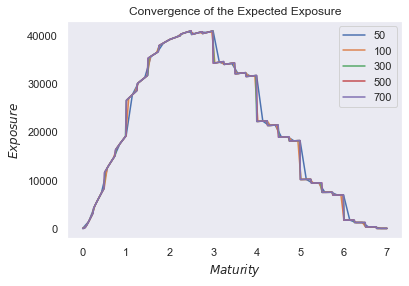

In [13]:
train_size_on_x = 5
n_std , n_reim = 5, 300

discretisations = [50,100,300,500,700]
intgp_df =  pd.DataFrame(columns=['Discretization','CVA', 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, ZC, quasi_analytic=True, GPR=True, train_size=train_size_on_x, n_std=n_std, integ_pts=n_reim) if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    intgp_df.loc[len(intgp_df)] = [ round(n) , cva, time() - mc_start]
    
   
    plt.plot(time_grid, EE, label=str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title('Convergence of the Expected Exposure')

    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))

In [14]:
intgp_df.astype(int)

,Discretization,CVA,Computation Time
0,50,436,27
1,100,430,59
2,300,431,206
3,500,432,351
4,700,432,450


In [15]:
intgp_df.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Convergence of CVA based on a numerical integration of GPR estimator with respect to  $X_{t}$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Convergence of CVA based on a numerical integration of GPR estimator with respect to  $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nDiscretization & CVA & Computation Time \\\\\n\\midrule\n50.000000 & 436.773447 & 27.029062 \\\\\n100.000000 & 430.352865 & 59.392326 \\\\\n300.000000 & 431.923630 & 206.440128 \\\\\n500.000000 & 432.104029 & 351.815224 \\\\\n700.000000 & 432.431955 & 450.370486 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

             In this case Applying a GPR on risk factor is not performant  as the benchmark (numerical integration) is fast. In fact, the time of GPR training is comparable to the time of the nuemrical integration. However the GPR is precise as the same level of precision of the benchmark

### 1.2. EE by Monte Carlo


Our numerical test in [Convergence EE CVA par Monte Carlo](/Project%201%20CVA%20MC-Integration/%20Convergence%20EE%20CVA%20par%20Monte%20Carlo.ipynb)  suggest the use of a 60000 simulations. 
We notice that we consider that CVA converge for $n=500$ for any chosen number of scenarios

In [86]:
mc_df.astype(int)

,Simulations Number,CVA,Computation Time
0,10000,434,1822
1,20000,431,2041
2,40000,434,1053
3,60000,431,2006
4,80000,431,3165
5,100000,431,9866


- Using a GPR on risk factor $X_{t}$  :

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Calulcaltion for 700 is Done ------
Total Calculation Time : 0:18:03


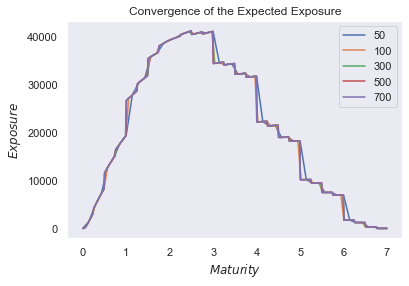

In [76]:
# Uncomment to run this calculation !!!  SLOW !!!!  WE USE A SAVED RESULTS 

train_size_on_x = 5


discretisations = [50,100,300,500,700]
mcgp_df =  pd.DataFrame(columns=['Discretization','CVA', 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, ZC,  GPR=True) if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    mcgp_df.loc[len(mcgp_df)] = [ round(n) , cva, time() - mc_start]
    
   
    plt.plot(time_grid, EE, label=str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title('Convergence of the Expected Exposure')

    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))




In [87]:
mcgp_df.astype(int)

,Discretization,CVA,Computation Time
0,50.0,437.003052,36.208457
1,100.0,430.597669,64.456898
2,300.0,432.151825,208.299680
3,500.0,432.334127,311.257063
4,700.0,432.661360,462.936286


                Contrary to numerical integration, the use of GPR acheive fastely the same accuracy in the context of Monte Carlo method : 5 min 11s for n=500 instead of 33min   

### 1.1. EE by proxy

In this section we calculate the $EE$ using a closed formula obtained trough a Gaussian proxy of $V(X_{t})$

In [9]:
def quad_norm(x) :
    return np.sum(np.sqrt(x))**2

def beta(t,T,lam):
    return (1 - np.exp(-lam * (T - t))) / lam

def A(t,T,lam, sig, ZC): 
    zcb_t, zcb_T=  ZC.initial_zcb_curve(t) , ZC.initial_zcb_curve(T)
    beta_ = beta(t,T,lam)
    phi = (sig ** 2 ) * (1 - np.exp(-2 * lam * t)) / (2 * lam)
    
    return (zcb_T / zcb_t) * np.exp(-0.5 * beta_ ** 2 * phi)
    
def zcb_law_lgm(t,T,lam,sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    mean = A(t,T,lam,sig,ZC) * ( 1 - beta(t,T,lam) * mu_X_t)
    std = std_X_t *A(t,T,lam,sig,ZC) * beta(t,T,lam)
    
    return mean, std


def swap_law(t,swap, lam, sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    if  swap.tenor[-2] < t:
        return 0,0
    else :
        swap_type = (swap.exercice == "payer") * 2 - 1
        maturities = swap.tenor[(swap.tenor < t).sum():]
        

        deltaK = np.zeros(maturities.shape[0])
        coef = np.zeros(maturities.shape[0])

        coef[0] = 1
        coef[-1] = -1

        deltaK[1:] = np.diff(maturities)*swap.strike

        coef = coef - deltaK

        A_ = A(t,maturities,lam, sig, ZC)
        M = A_*beta(t,maturities,lam)

        mean  = swap_type*swap.nominal*(np.dot(coef,A_) - np.dot(coef,M)*mu_X_t)

        std = swap.nominal*np.dot(coef,M)*std_X_t

        return mean , std

def Mtm_proxy_law(t, portfolio, lam, sig, ZC):
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad_norm(std_swaps**2)
    mean = np.sum(mean_swaps)
    

    return mean , np.sqrt(var)

def Expected_exposure_proxy(t, portfolio, lam, sig, ZC) :
    mu , sigma = Mtm_proxy_law(t, portfolio, lam, sig, ZC)
    if sigma == 0:
        return 0
    return ZC.initial_zcb_curve(t)*(mu*norm.cdf(mu/sigma) + sigma*norm.pdf(mu/sigma))
    

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Calulcaltion for 700 is Done ------
Calulcaltion for 800 is Done ------
Total Calculation Time : 0:02:32


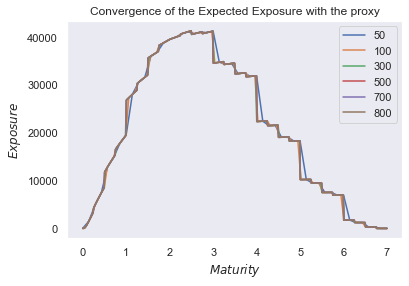

In [10]:

discretisations =[50,100,300,500,700,800]

proxy_df =  pd.DataFrame(columns=['Discretization', 'CVA' , 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()

    EE =np.array([ Expected_exposure_proxy(t, portfolio, diffusion.get_LGM_params()[0],diffusion.get_LGM_params()[1], ZC)  if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    proxy_df.loc[len(proxy_df)] = [ round(n) , cva, time() - mc_start]
    
   
    plt.plot(time_grid, EE, label=str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title("Convergence of the Expected Exposure with the proxy")
    
    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))

In [11]:
proxy_df.astype(int)

,Discretization,CVA,Computation Time
0,50,440,3
1,100,433,5
2,300,435,18
3,500,435,33
4,700,436,43
5,800,435,47


The proxy is fast and converge for $n=500$ to $435 \, €$ at 33s

## 2. CVA by Bayesian Quadrature

In this section, we calculate the CVA of our portfolio by a Bayesian Quadrature instead a Reimman sum for the integral with respect to time. 

To do we calculate EE for the trained data $ \mathcal{D}_{n} = \left(t_{i}, EE(t_{i}) PD^{\prime}(t) \right)_{1 \le i \le n} $ as in section 1 by 3 methods : Numerical integration, Monte Carlo and proxy

*NB : in our case $PD^{\prime}(t)$ is explicit trough an expontial intensity model with constant default intensity*

### 2.1. EE by numerical integration 

time : 1
Nodes numbers 5
time : 3
Nodes numbers 10
time : 5
Nodes numbers 15
time : 6
Nodes numbers 20
time : 9
Nodes numbers 25
time : 10
Nodes numbers 30
time : 10
Nodes numbers 35
time : 11
Nodes numbers 40


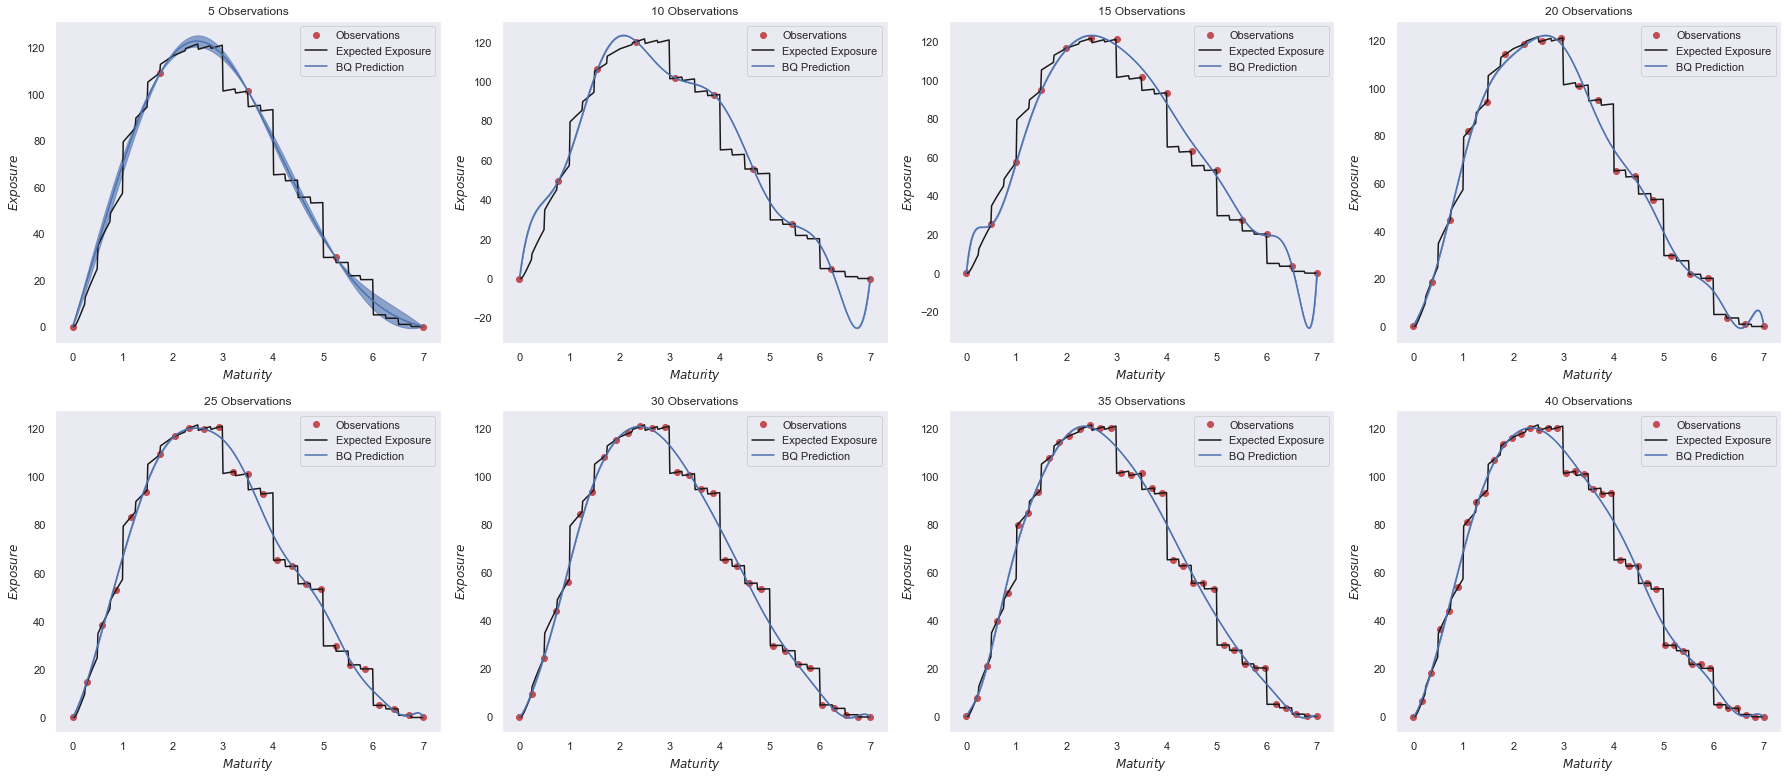

<Figure size 432x288 with 0 Axes>

In [47]:
n_std , n_reim = 5, 300

lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

d = 5
nd = 8

bq_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])


fig, axes = plt.subplots(2,4, figsize=(25, 11)) 

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, ZC, quasi_analytic=True , n_std = n_std, integ_pts=n_reim) ] if 0<t and t<T else [0] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :',round( sec_time))
    
    bq_df.loc[len(bq_df)] = [(i+1)*d, bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_bench)) ])
    Y_bench = (1-R)*EE_bench*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    plt.subplot(2,4,i+1)

    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_bench)), Y_bench, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    
fig.tight_layout()
plt.show()
plt.savefig(img_path+ '/P400F1_BQ'+ str(i)+'.png')

    

In [48]:
get_synthetic_table(bq_df, 3, bench_df, mtm ,'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,439,0.14,0,74
1,10,434,0.04,2,28
2,15,446,0.27,4,14
3,20,431,0.01,5,12
4,25,433,0.03,8,8
5,30,423,0.16,10,6
6,35,435,0.06,9,7
7,40,432,0.01,11,6


where $Relative  Error = \frac{|CVA_{predicted} \, - \, CVA_{Benchmark} |}{|MtM_{0}|}$ is expressed in point basis

In [78]:
get_synthetic_table(bq_df, 3, bench_df, mtm ,'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by numerical integration.$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by numerical integration.$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 439 & 0.140000 & 0 & 74 \\\\\n10 & 434 & 0.040000 & 2 & 28 \\\\\n15 & 446 & 0.270000 & 4 & 14 \\\\\n20 & 431 & 0.010000 & 5 & 12 \\\\\n25 & 433 & 0.030000 & 8 & 8 \\\\\n30 & 423 & 0.160000 & 10 & 6 \\\\\n35 & 435 & 0.060000 & 9 & 7 \\\\\n40 & 432 & 0.010000 & 11 & 6 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

- Using a GPR on risk factor $X_{t}$  :

In [20]:
train_size_on_x = 5 

time : 2
Nodds numbers 5
time : 4
Nodds numbers 10
time : 8
Nodds numbers 15
time : 10
Nodds numbers 20
time : 14
Nodds numbers 25
time : 17
Nodds numbers 30
time : 25
Nodds numbers 35
time : 26
Nodds numbers 40


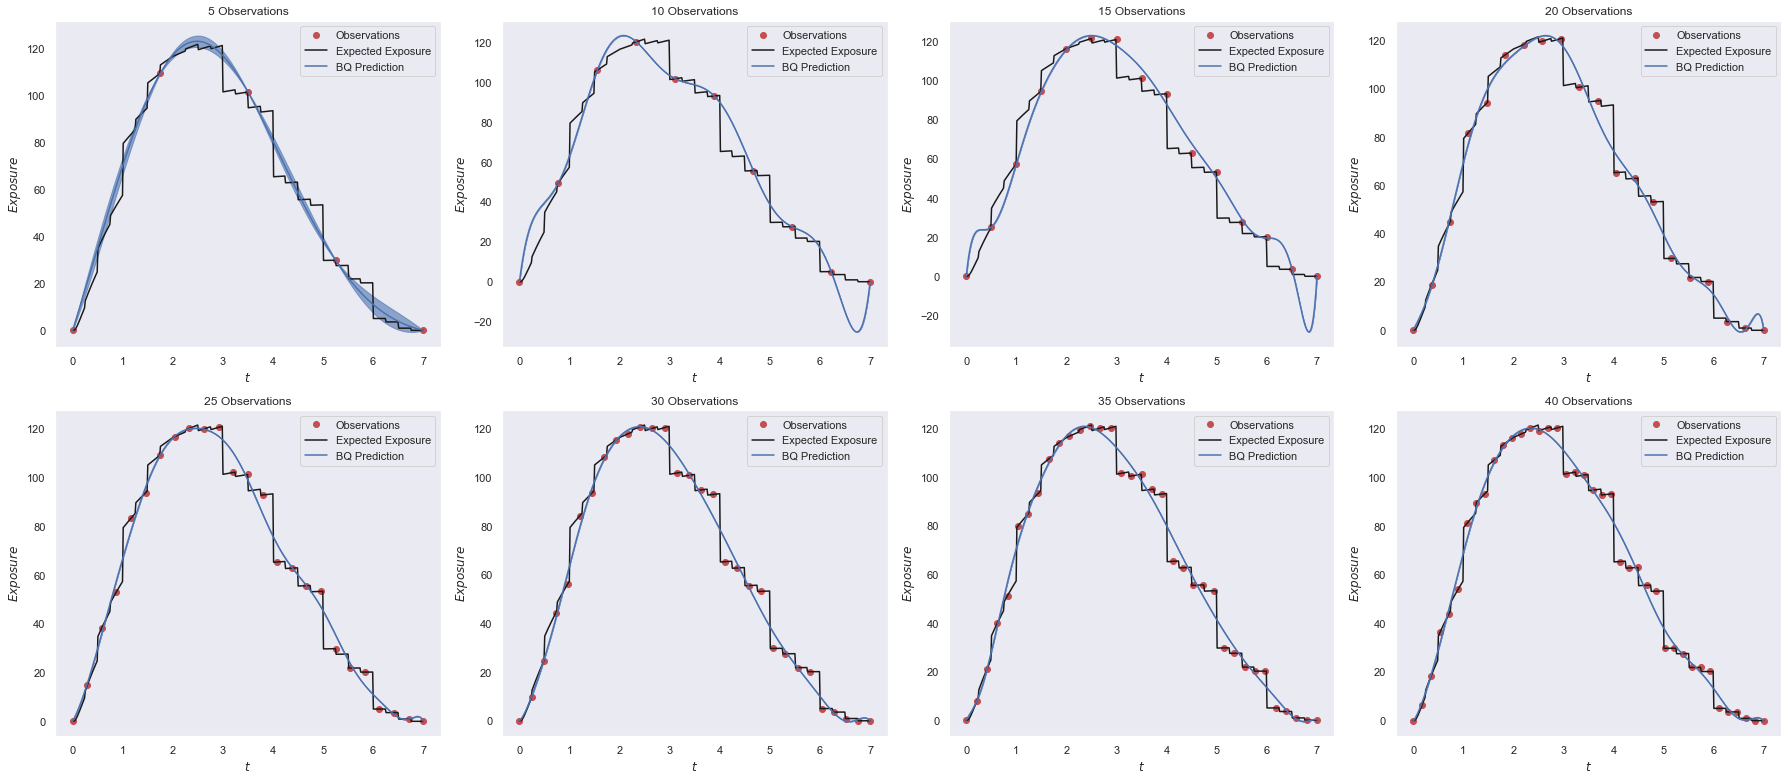

<Figure size 432x288 with 0 Axes>

In [51]:
n_std , n_reim = 5, 300

lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

d = 5
nd = 8

bqqa_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

fig, axes = plt.subplots(2,4, figsize=(25, 11)) 

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, ZC, quasi_analytic=True , GPR=True, train_size=train_size_on_x, n_std = n_std, integ_pts=n_reim) ] if 0<t and t<T else [0] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', round(sec_time))
    
    bqqa_df.loc[len(bqqa_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_bench)) ])
    Y_bench = (1-R)*EE_bench*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodds numbers', (i+1)*d)
    
    plt.subplot(2,4,i+1)
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_bench)), Y_bench, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')

fig.tight_layout()   
plt.show()
plt.savefig(img_path+ '/P400F1_BQ_GPR_QuasiAnalytic__trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')

In [52]:
get_synthetic_table(bqqa_df, 3, bench_df, mtm ,'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,439,0.14,1,40
1,10,434,0.04,4,17
2,15,446,0.27,7,9
3,20,431,0.01,10,7
4,25,433,0.03,13,5
5,30,423,0.16,17,4
6,35,435,0.06,24,2
7,40,432,0.01,25,2


In [79]:
get_synthetic_table(bqqa_df, 3, bench_df, mtm , 'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points and an expected exposure calculated by a numerical integration involoving a trained GPR on $X_{t}$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)


'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points and an expected exposure calculated by a numerical integration involoving a trained GPR on $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

     As we showed in section 1 , applying the GPR approximation for the numerical integration still precise but is more slow

### 2.2. EE by Monte Carlo 

Only in this section the becnhmark will be the one calculated in the section 1.2 corresponding to the full MC with 60000 simulations and $n=500$

Here we will not excute calculation as we have done it previously, however to have the figures we should run the commented code 

In [ ]:
# lb , ub = 0,T
# x_plot = np.linspace(lb, ub, 300)[:, None]

# d = 5
# nd = 8

# bqmc_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

# fig, axes = plt.subplots(2,4, figsize=(25, 11)) 

# for i in range(nd):
#     start_time = time()
   
#     integ_points = np.linspace(0,T,(i+1)*d) 
    
#     X = np.array([ [t] for t in integ_points ])
#     EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, ZC) ] if 0<t and t<T else [0] for t in integ_points ])
#     PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
#     Y = (1-R)*EE*PD
    
#     bq = BQ(X,Y, lb, ub)
    
#     sec_time =time()-start_time
#     print('time :', round(sec_time))
    
#     bqmc_df.loc[len(bqmc_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
#     PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
#     Y_MC= (1-R)*EE_MC*PD_full
    
#     mu_plot, var_plot = bq.predict(x_plot)
    
#     print('Nodes numbers', (i+1)*d)
    
#     plt.subplot(2,4,i+1)
#     plt.plot(X, Y, "ro", markersize=6, label="Observations")
#     plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

#     plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
#     plt.fill_between(x_plot[:, 0],
#                      mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                      mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

#     plt.legend()
#     plt.xlabel(r"$t$")
#     plt.ylabel(r"$Exposure$")
#     plt.grid(False)
#     plt.title( str((i+1)*d) + ' Observations')

# fig.tight_layout()   
# plt.show()
# plt.savefig(img_path+ '/P400F1_BQ_MC'+str(i)+'t'+'.png')

In [70]:
BQMC_path = project_path + '\Results\BQ MC 60000'
with open(BQMC_path+'\GPRMC60000_P400sf1' ,'rb') as f:
    bqmc_df = pickle.load(f)


In [71]:
get_synthetic_table(bqmc_df, 3, mc_df, mtm ,'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,439,0.16,85,23
1,10,434,0.06,159,12
2,15,447,0.29,234,8
3,20,431,0.01,298,6
4,25,434,0.06,450,4
5,30,423,0.14,678,2
6,35,435,0.08,6540,0
7,40,432,0.03,870,2


In [80]:
get_synthetic_table(bqmc_df, 3, mc_df, mtm , 'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by Monte Carlo$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)


'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by Monte Carlo$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 439 & 0.160000 & 85 & 23 \\\\\n10 & 434 & 0.060000 & 159 & 12 \\\\\n15 & 447 & 0.290000 & 234 & 8 \\\\\n20 & 431 & 0.010000 & 298 & 6 \\\\\n25 & 434 & 0.060000 & 450 & 4 \\\\\n30 & 423 & 0.140000 & 678 & 2 \\\\\n35 & 435 & 0.080000 & 6540 & 0 \\\\\n40 & 432 & 0.030000 & 870 & 2 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

- Using a GPR on risk factor $X_{t}$  :

time : 2
Nodes numbers 5
time : 5
Nodes numbers 10
time : 8
Nodes numbers 15
time : 12
Nodes numbers 20
time : 17
Nodes numbers 25
time : 24
Nodes numbers 30
time : 25
Nodes numbers 35
time : 31
Nodes numbers 40


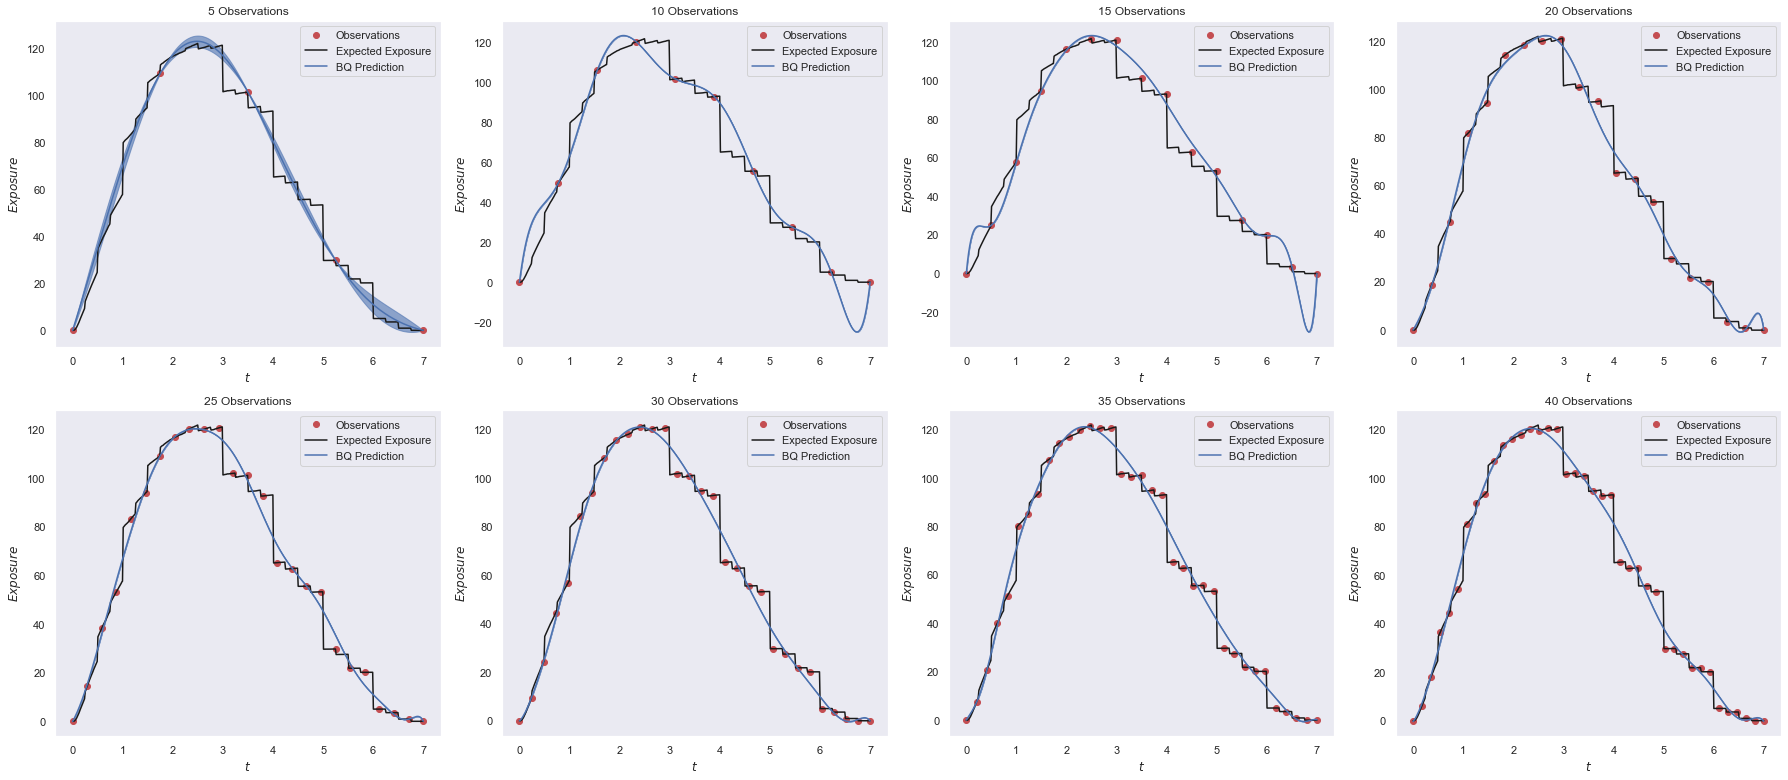

<Figure size 432x288 with 0 Axes>

In [69]:
lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

d = 5
nd = 8

bqmcgp_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

fig, axes = plt.subplots(2,4, figsize=(25, 11)) 

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, ZC, GPR=True, train_size=train_size_on_x) ] if 0<t and t<T else [0] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', round(sec_time))
    
    bqmcgp_df.loc[len(bqmcgp_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC= (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    
    plt.subplot(2,4,i+1)
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')

fig.tight_layout()   
plt.show()
plt.savefig(img_path+ '/P400F1_BQ_MC'+str(i)+'t'+'.png')

In [73]:
get_synthetic_table(bqmcgp_df, 3, mc_df, mtm ,'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,439,0.16,1,1144
1,10,434,0.06,4,434
2,15,447,0.29,8,243
3,20,431,0.01,12,160
4,25,434,0.06,16,119
5,30,423,0.14,23,85
6,35,435,0.08,25,79
7,40,432,0.03,31,64


In [81]:
get_synthetic_table(bqmcgp_df, 3, mc_df, mtm , 'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by Monte Carlo method involoving a trained GPR on $X_{t}$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points with an expected exposure calculated by Monte Carlo method involoving a trained GPR on $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 439 & 0.160000 & 1 & 1144 \\\\\n10 & 434 & 0.060000 & 4 & 434 \\\\\n15 & 447 & 0.290000 & 8 & 243 \\\\\n20 & 431 & 0.010000 & 12 & 160 \\\\\n25 & 434 & 0.060000 & 16 & 119 \\\\\n30 & 423 & 0.140000 & 23 & 85 \\\\\n35 & 435 & 0.080000 & 25 & 79 \\\\\n40 & 432 & 0.030000 & 31 & 64 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

                    In the context of Monte Carlo method, the use of GPR acheive fastely the same accuracy 

### 2.3. EE by proxy 

time : 0.48
Nodds numbers 5
time : 0.71
Nodds numbers 10
time : 0.97
Nodds numbers 15
time : 1.49
Nodds numbers 20
time : 1.88
Nodds numbers 25
time : 2.0
Nodds numbers 30
time : 2.19
Nodds numbers 35
time : 2.45
Nodds numbers 40
time : 2.87
Nodds numbers 45


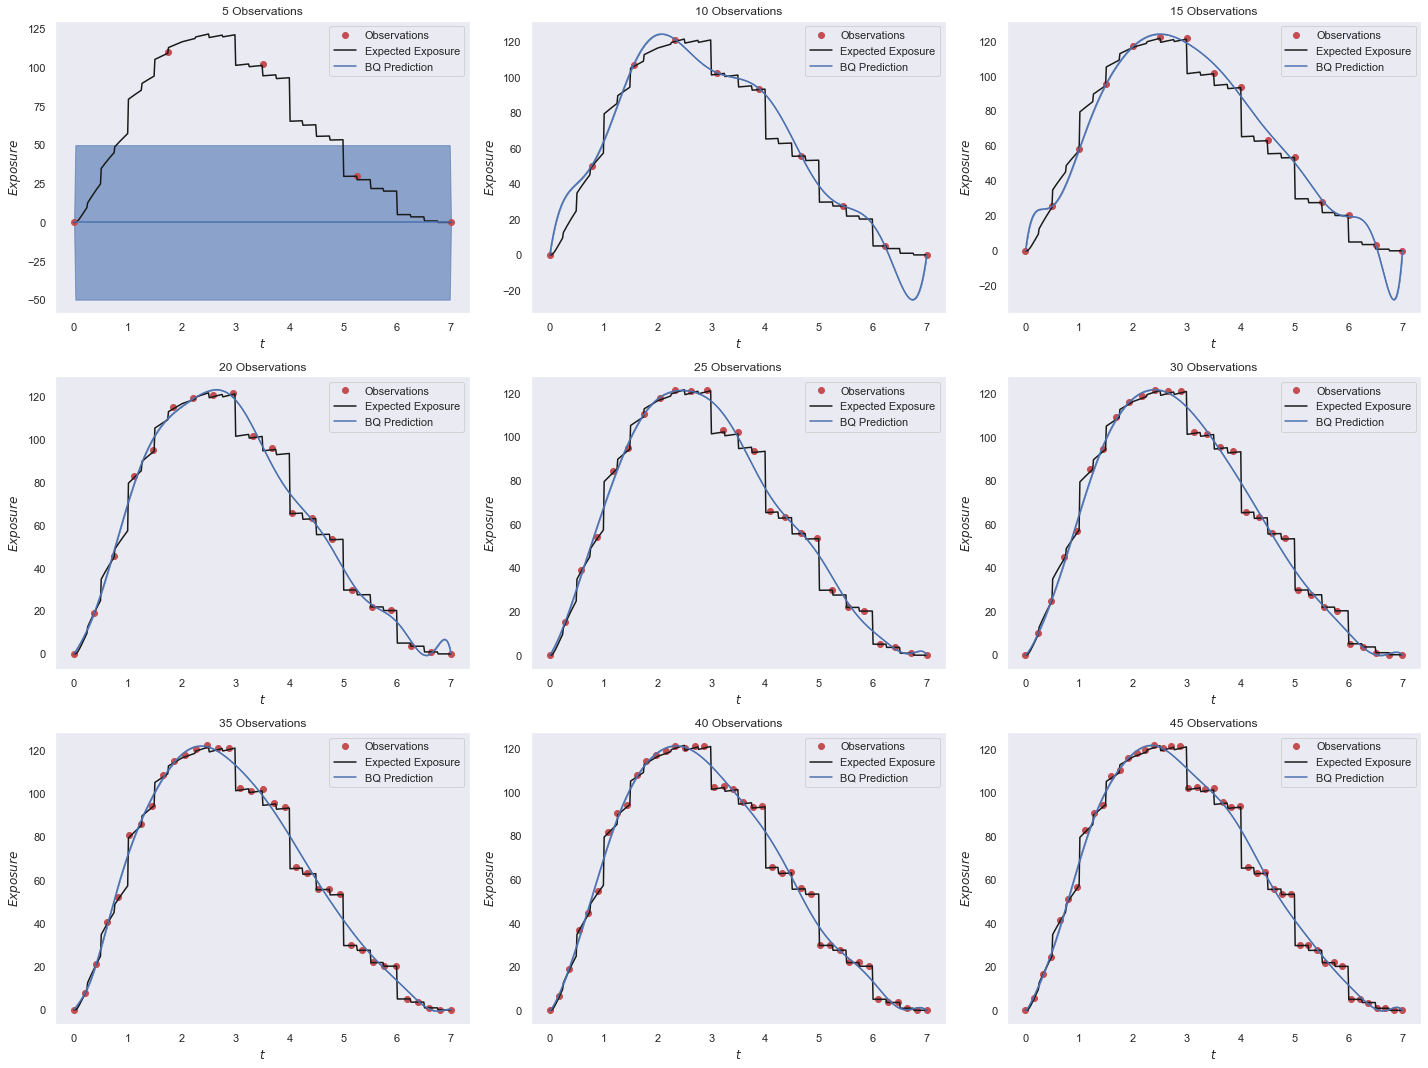

<Figure size 432x288 with 0 Axes>

In [61]:
lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

lam,sig = diffusion.get_LGM_params()

d = 5
nd = 9

bqproxy_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])
fig, axes = plt.subplots(3,3, figsize=(20, 15)) 

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])

    EE = np.array([ [ Expected_exposure_proxy(t, portfolio, lam, sig, ZC)] if 0<t and t<T else [0] for t in integ_points] )
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', round(sec_time,2))
    
    bqproxy_df.loc[len(bqproxy_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_bench)) ])
    Y_bench = (1-R)*EE_bench*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodds numbers', (i+1)*d)
    
    plt.subplot(3,3,i+1)
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_bench)), Y_bench, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
fig.tight_layout()    
plt.show()
plt.savefig(img_path+ '/P400F1_BQ_proxy__trained'+ str(i)+'t'+'.png')


In [59]:
rounded_df = get_synthetic_table(bqproxy_df, 3, bench_df, mtm ,'Bayesian Quadrature Prediction')

rounded_df['Computation Time'] = bqproxy_df['Computation Time'].round(1)
rounded_df

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,0,7.93,0.3,268
1,10,437,0.10,0.7,104
2,15,450,0.34,1.1,65
3,20,434,0.05,1.5,47
4,25,437,0.10,1.6,46
5,30,426,0.09,2.0,36
6,35,438,0.12,2.3,31
7,40,436,0.07,2.8,25
8,45,435,0.06,2.9,25


In [82]:
rounded_df.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on proxy for the training $",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on proxy for the training $}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 0 & 7.930000 & 0.300000 & 268 \\\\\n10 & 437 & 0.100000 & 0.700000 & 104 \\\\\n15 & 450 & 0.340000 & 1.100000 & 65 \\\\\n20 & 434 & 0.050000 & 1.500000 & 47 \\\\\n25 & 437 & 0.100000 & 1.600000 & 46 \\\\\n30 & 426 & 0.090000 & 2.000000 & 36 \\\\\n35 & 438 & 0.120000 & 2.300000 & 31 \\\\\n40 & 436 & 0.070000 & 2.800000 & 25 \\\\\n45 & 435 & 0.060000 & 2.900000 & 25 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

As expected this method is the most performant in our case study